# A2: NeuralNetwork Class

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Requirements" data-toc-modified-id="Requirements-1">Requirements</a></span></li><li><span><a href="#Code-for-NeuralNetwork-Class" data-toc-modified-id="Code-for-NeuralNetwork-Class-2">Code for <code>NeuralNetwork</code> Class</a></span></li><li><span><a href="#Example-Results" data-toc-modified-id="Example-Results-3">Example Results</a></span></li><li><span><a href="#Application-to-Boston-Housing-Data" data-toc-modified-id="Application-to-Boston-Housing-Data-4">Application to Boston Housing Data</a></span></li></ul></div>

## Requirements

In this assignment, you will complete the implementation of the `NeuralNetwork` class, starting with the code included in the next code cell.  Your implementation must meet the requirements described in the doc-strings.

Then apply your `NeuralNetwork` class to the problem of predicting the value of houses in Boston as described below.

## Code for `NeuralNetwork` Class

In [2]:
%%writefile neuralnetwork.py

import numpy as np
import optimizers as opt


class NeuralNetwork():
    """
    A class that represents a neural network for nonlinear regression

    Attributes
    ----------
    n_inputs : int
        The number of values in each sample
    n_hidden_units_by_layers: list of ints, or empty
        The number of units in each hidden layer.
        Its length specifies the number of hidden layers.
    n_outputs: int
        The number of units in output layer
    all_weights : one-dimensional numpy array
        Contains all weights of the network as a vector
    Ws : list of two-dimensional numpy arrays
        Contains matrices of weights in each layer,
        as views into all_weights
    all_gradients : one-dimensional numpy array
        Contains all gradients of mean square error with
        respect to each weight in the network as a vector
    Grads : list of two-dimensional numpy arrays
        Contains matrices of gradients weights in each layer,
        as views into all_gradients
    total_epochs : int
        Total number of epochs trained so far
    error_trace : list
        Mean square error (standardized) after each epoch
    X_means : one-dimensional numpy array
        Means of the components, or features, across samples
    X_stds : one-dimensional numpy array
        Standard deviations of the components, or features, across samples
    T_means : one-dimensional numpy array
        Means of the components of the targets, across samples
    T_stds : one-dimensional numpy array
        Standard deviations of the components of the targets, across samples
        
    Methods
    -------
    make_weights_and_views(shapes)
        Creates all initial weights and views for each layer

    train(X, T, n_epochs, method='sgd', learning_rate=None, verbose=True)
        Trains the network using samples by rows in X and T

    use(X)
        Applies network to inputs X and returns network's output
    """

    def __init__(self, n_inputs, n_hidden_units_by_layers, n_outputs):
        """Creates a neural network with the given structure

        Parameters
        ----------
        n_inputs : int
            The number of values in each sample
        n_hidden_units_by_layers : list of ints, or empty
            The number of units in each hidden layer.
            Its length specifies the number of hidden layers.
        n_outputs : int
            The number of units in output layer

        Returns
        -------
        NeuralNetwork object
        """

        # Assign attribute values. Set self.X_means to None to indicate
        # that standardization parameters have not been calculated.
        # ....
        self.n_inputs = n_inputs
        self.n_hidden_units_by_layers = n_hidden_units_by_layers
        self.n_outputs = n_outputs
        self.total_epochs = 0
        self.error_trace = []
        self.X_means = None
        self.X_stds = None
        self.T_means = None
        self.T_stds = None
        
        # Build list of shapes for weight matrices in each layer
        # ...
        shapes = []
        if n_hidden_units_by_layers:
            for n in range(len(n_hidden_units_by_layers)):
                if n == 0:
                    shapes.append((n_inputs, n_hidden_units_by_layers[n]))
                else:
                    shapes.append((n_hidden_units_by_layers[n-1], n_hidden_units_by_layers[n]))

            shapes.append((n_hidden_units_by_layers[len(n_hidden_units_by_layers)-1], n_outputs))
        else:
            # no hidden layers, i.e. empty list passed in for n_hidden_units_by_layers
            shapes.append((n_inputs, n_outputs))
        
        # Call make_weights_and_views to create all_weights and Ws
        # ...
        self.all_weights, self.Ws = self.make_weights_and_views(shapes)
        
        # Call make_weights_and_views to create all_gradients and Grads
        # ...
        self.all_gradients, self.Grads = self.make_weights_and_views(shapes)


    def make_weights_and_views(self, shapes):
        """Creates vector of all weights and views for each layer

        Parameters
        ----------
        shapes : list of pairs of ints
            Each pair is number of rows and columns of weights in each layer

        Returns
        -------
        Vector of all weights, and list of views into this vector for each layer
        """

        # Create one-dimensional numpy array of all weights with random initial values
        #  ...
        array_size = 0
        for shape in shapes:
            array_size += (shape[0] * shape[1])
        all_weights = np.random.uniform(-1, 1, size=array_size)
        
        # Build list of views by reshaping corresponding elements
        # from vector of all weights into correct shape for each layer.        
        # ...
        #TODO make sure division makes sense / np.sqrt(shapes[0]
        views = []
        index = 0
        new_index = 0
        for shape in shapes:
            new_index += (shape[0] * shape[1])
            views.append(all_weights[index:new_index].reshape(shape[0], shape[1]))
            index = new_index
             
        return all_weights, views
                      
                      
    def __repr__(self):
        return f'NeuralNetwork({self.n_inputs}, ' + \
            f'{self.n_hidden_units_by_layers}, {self.n_outputs})'

    def __str__(self):
        s = self.__repr__()
        if self.total_epochs > 0:
            s += f'\n Trained for {self.total_epochs} epochs.'
            s += f'\n Final standardized training error {self.error_trace[-1]:.4g}.'
        return s
 
    def train(self, X, T, n_epochs, method='sgd', learning_rate=None, verbose=True):
        """Updates the weights 

        Parameters
        ----------
        X : two-dimensional numpy array
            number of samples  x  number of input components
        T : two-dimensional numpy array
            number of samples  x  number of output components
        n_epochs : int
            Number of passes to take through all samples
        method : str
            'sgd', 'adam', or 'scg'
        learning_rate : float
            Controls the step size of each update, only for sgd and adam
        verbose: boolean
            If True, progress is shown with print statements
        """

        # Calculate and assign standardization parameters
        # ...


            
        self.X_means = X.mean(axis=0)
        self.X_stds = X.std(axis=0)
        self.T_means = T.mean(axis=0)
        self.T_stds = T.std(axis=0)
        
        # Standardize X and T
        # ...
        #TODO double check
        XS = (X - self.X_means) / self.X_stds
        TS = (T - self.T_means) / self.T_stds
        
        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = opt.Optimizers(self.all_weights)
        error_convert_f = lambda err: (np.sqrt(err) * self.T_stds)[0]
        # Call the requested optimizer method to train the weights.

        if method == 'sgd':
            
            error_trace = optimizer.sgd(self.error_f, self.gradient_f, fargs=[XS, TS], n_epochs=n_epochs, learning_rate=learning_rate, verbose=verbose,
               error_convert_f=error_convert_f)

        elif method == 'adam':

            error_trace = optimizer.adam(self.error_f, self.gradient_f, fargs=[XS, TS], n_epochs=n_epochs, learning_rate=learning_rate, verbose=verbose,
               error_convert_f=error_convert_f)

        elif method == 'scg':

            error_trace = optimizer.scg(self.error_f, self.gradient_f, fargs=[XS, TS], n_epochs=n_epochs, verbose=verbose,
               error_convert_f=error_convert_f)

        else:
            raise Exception("method must be 'sgd', 'adam', or 'scg'")

        self.total_epochs += len(error_trace)
        self.error_trace += error_trace

        # Return neural network object to allow applying other methods
        # after training, such as:    Y = nnet.train(X, T, 100, 0.01).use(X)

        return self

    def _forward(self, X):
        """Calculate outputs of each layer given inputs in X
        
        Parameters
        ----------
        X : input samples, standardized

        Returns
        -------
        Outputs of all layers as list
        """
        self.Ys = [X]
        
        # Append output of each layer to list in self.Ys, then return it.
        # ...
        for i in range(len(self.Ws)):
            self.Ys.append(np.tanh(self.Ys[i] @ self.Ws[i]))
        return self.Ys
    
    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        """Calculate output of net and its mean squared error 

        Parameters
        ----------
        X : two-dimensional numpy array
            number of samples  x  number of input components
        T : two-dimensional numpy array
            number of samples  x  number of output components

        Returns
        -------
        Mean square error as scalar float that is the mean
        square error over all samples
        """
        # Call _forward, calculate mean square error and return it.
        # ...
        error = (T - self._forward(X)[-1])
        return np.sqrt(np.mean(error ** 2))

#     Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):
        """Returns gradient wrt all weights. Assumes _forward already called.

        Parameters
        ----------
        X : two-dimensional numpy array
            number of samples  x  number of input components
        T : two-dimensional numpy array
            number of samples  x  number of output components

        Returns
        -------
        Vector of gradients of mean square error wrt all weights
        """

        # Assumes forward_pass just called with layer outputs saved in self.Ys.
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        n_layers = len(self.n_hidden_units_by_layers) + 1

        # D is delta matrix to be back propagated
        D = -(T - self.Ys[-1]) / (n_samples * n_outputs)

        # Step backwards through the layers to back-propagate the error (D)
        for layeri in range(n_layers - 1, -1, -1):
            
            # gradient of all but bias weights
            self.Grads[layeri][1:, :] = (self.Ys[layeri].T @ D)[1:, :]
            # gradient of just the bias weights
            self.Grads[layeri][0:1, :] = np.sum(D, axis=0)
            # Back-propagate this layer's delta to previous layer
            if layeri > 0:
                D = - D @ self.Ws[layeri].T * (1-self.Ys[layeri]**2)
                    
        return self.all_gradients

    def use(self, X):
        """Return the output of the network for input samples as rows in X

        Parameters
        ----------
        X : two-dimensional numpy array
            number of samples  x  number of input components, unstandardized

        Returns
        -------
        Output of neural network, unstandardized, as numpy array
        of shape  number of samples  x  number of outputs
        """

        # Standardize X
        # ...
        X_means = X.mean(axis=0)
        X_stds = X.std(axis=0)
        XS = (X - X_means) / X_stds
        
        # Unstandardize output Y before returning it
        
        return self._forward(XS)[-1] * self.T_stds + self.T_means

    def get_error_trace(self):
        """Returns list of standardized mean square error for each epoch"""
        return self.error_trace

Overwriting neuralnetwork.py


## Example Results

Here we test the `NeuralNetwork` class with some simple data.  

sgd: Epoch 5000 ObjectiveF=0.53849
sgd: Epoch 10000 ObjectiveF=0.53798
sgd: Epoch 15000 ObjectiveF=0.53782
sgd: Epoch 20000 ObjectiveF=0.54256
sgd: Epoch 25000 ObjectiveF=0.53778
sgd: Epoch 30000 ObjectiveF=0.53794
sgd: Epoch 35000 ObjectiveF=0.53822
sgd: Epoch 40000 ObjectiveF=0.53785
sgd: Epoch 45000 ObjectiveF=0.53821
sgd: Epoch 50000 ObjectiveF=0.53796
Adam: Epoch 5000 ObjectiveF=0.54952
Adam: Epoch 10000 ObjectiveF=0.57023
Adam: Epoch 15000 ObjectiveF=0.62618
Adam: Epoch 20000 ObjectiveF=0.53896
Adam: Epoch 25000 ObjectiveF=0.57557
Adam: Epoch 30000 ObjectiveF=0.54649
Adam: Epoch 35000 ObjectiveF=0.63589
Adam: Epoch 40000 ObjectiveF=0.54186
Adam: Epoch 45000 ObjectiveF=0.59255
Adam: Epoch 50000 ObjectiveF=0.53829
SCG: Epoch 5000 ObjectiveF=0.57695
SCG: Epoch 10000 ObjectiveF=0.57695
SCG: Epoch 15000 ObjectiveF=0.57695
SCG: Epoch 20000 ObjectiveF=0.57695
SCG: Epoch 25000 ObjectiveF=0.57695
SCG: Epoch 30000 ObjectiveF=0.57695
SCG: Epoch 35000 ObjectiveF=0.57695
SCG: Epoch 40000 Obje

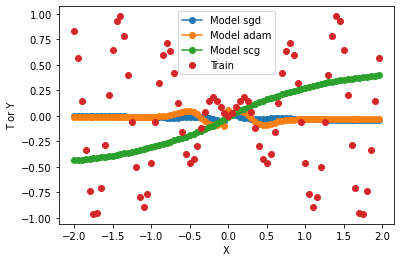

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import neuralnetwork as nn

X = np.arange(-2, 2, 0.05).reshape(-1, 1)
T = np.sin(X) * np.sin(X * 10)

errors = []
n_epochs = 1000
method_rhos = [('sgd', 0.01),
               ('adam', 0.005),
               ('scg', None)]

for method, rho in method_rhos:
    nnet = nn.NeuralNetwork(X.shape[1], [10, 10], 1)
    nnet.train(X, T, 50000, method=method, learning_rate=rho)
    Y = nnet.use(X)
    plt.plot(X, Y, 'o-', label='Model ' + method)
    errors.append(nnet.get_error_trace())

plt.plot(X, T, 'o', label='Train')
plt.xlabel('X')
plt.ylabel('T or Y')
plt.legend();

In [3]:
import numpy as np
from neuralnetwork import NeuralNetwork
nn = NeuralNetwork(2, [2], 1)
X = np.array([[1,2],
    [4,5],
    [7,8]])
T=np.array([[4],
    [5],
    [6]])
nn.train(X, T, 3,  method='sgd', learning_rate=0.005, verbose=True)
print(nn.use(X))
nn = NeuralNetwork(2, [], 1)
nn.train(X, T, 3,  method='sgd', learning_rate=0.005, verbose=True)
print(nn.use(X))
# nn = NeuralNetwork(3, [3], 1)
# X = np.array([[1,2, 3],
#     [4,5,6],
#     [7,8,9]])
# T=np.array([[4],
#     [5],
#     [6]])
# nn.train(X, T, 3,  method='sgd', learning_rate=0.005, verbose=True)

sgd: Epoch 1 ObjectiveF=0.87559
sgd: Epoch 2 ObjectiveF=0.87521
sgd: Epoch 3 ObjectiveF=0.87448
[[5.14434493]
 [5.        ]
 [4.85565507]]
sgd: Epoch 1 ObjectiveF=0.45389
sgd: Epoch 2 ObjectiveF=0.45357
sgd: Epoch 3 ObjectiveF=0.45296
[[4.30658466]
 [5.        ]
 [5.69341534]]


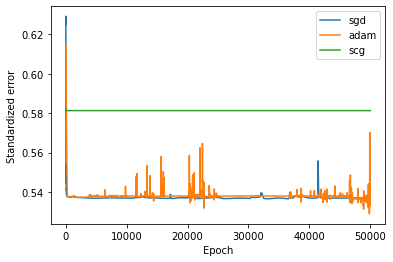

In [4]:
plt.figure(2)
plt.clf()
for error_trace in errors:
    plt.plot(error_trace)
plt.xlabel('Epoch')
plt.ylabel('Standardized error')
plt.legend([mr[0] for mr in method_rhos]);

## Application to Boston Housing Data

Download data from [Boston House Data at Kaggle](https://www.kaggle.com/fedesoriano/the-boston-houseprice-data). Read it into python using the `pandas.read_csv` function.  Assign the first 13 columns as inputs to `X` and the final column as target values to `T`.  Make sure `T` is two-dimensional.

Before training your neural networks, partition the data into training and testing partitions, as shown here.

In [5]:
def partition(X, T, train_fraction):
    n_samples = X.shape[0]
    rows = np.arange(n_samples)
    np.random.shuffle(rows)
    
    n_train = round(n_samples * train_fraction)
    
    Xtrain = X[rows[:n_train], :]
    Ttrain = T[rows[:n_train], :]
    Xtest = X[rows[n_train:], :]
    Ttest = T[rows[n_train:], :]
    return Xtrain, Ttrain, Xtest, Ttest
def rmse(T, Y):
    return np.sqrt(np.mean((T - Y)**2))

Write and run code using your NeuralNetwork class to model the Boston housing data. Experiment with all three optimization methods and a variety of neural network structures (numbers of hidden layer and units), learning rates, and numbers of epochs. Show results for at least three different network structures, learning rates, and numbers of epochs for each method. Show your results using print statements that include the method, network structure, number of epochs, learning rate, and RMSE on training data and RMSE on testing data.

Try to find good values for the RMSE on testing data. Discuss your results, including how good you think the RMSE values are by considering the range of house values given in the data. 

In [6]:
import numpy as np
import pandas
import neuralnetwork as nn

data = pandas.read_csv('boston.csv')
data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


In [7]:
T = data.to_numpy()[:, -1].reshape(-1,1)
X = data.to_numpy()[:, 0:13]
X.shape, T.shape

# Assuming you have assigned `X` and `T` correctly.

Xtrain, Ttrain, Xtest, Ttest = partition(X, T, 0.8)  

# n_samples = X.shape[0]
# rows = np.arange(n_samples)

# np.random.shuffle(rows)
# rows

# n_train = round(n_samples * 0.8)
# Xtrain = X[rows[:n_train], :]
# Ttrain = T[rows[:n_train], :]

# Xtest = X[rows[n_train:], :]
# Ttest = T[rows[n_train:], :]

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape
nn = NeuralNetwork(13, [2], 1)
nn.train(Xtrain, Ttrain, 3,  method='sgd', learning_rate=0.005, verbose=True)

sgd: Epoch 1 ObjectiveF=9.80318
sgd: Epoch 2 ObjectiveF=9.79919
sgd: Epoch 3 ObjectiveF=9.79167


NeuralNetwork(13, [2], 1)

In [13]:
nn = NeuralNetwork(13, [2], 1)
nn.train(Xtrain, Ttrain, 3,  method='sgd', learning_rate=0.005, verbose=True)
Y = nn.use(Xtest)
err = rmse(Y, Ttest)
print(err)

sgd: Epoch 1 ObjectiveF=10.04442
sgd: Epoch 2 ObjectiveF=10.04948
sgd: Epoch 3 ObjectiveF=10.05893
10.906546789455055


# Grading

Your notebook will be run and graded automatically. Test this grading process by first downloading [A2grader.tar](http://www.cs.colostate.edu/~anderson/cs545/notebooks/A2grader.tar) and extract `A2grader.py` from it. Run the code in the following cell to demonstrate an example grading session.  The remaining 20 points will be based on your discussion of this assignment.

A different, but similar, grading script will be used to grade your checked-in notebook. It will include additional tests. You should design and perform additional tests on all of your functions to be sure they run correctly before checking in your notebook.  

For the grading script to run correctly, you must first name this notebook as 'Lastname-A2.ipynb' with 'Lastname' being your last name, and then save this notebook.

In [9]:
import numpy as np
from neuralnetwork import NeuralNetwork
n_inputs = 3
n_hiddens = [10, 20]
n_outputs = 2
n_samples = 5

X = np.arange(n_samples * n_inputs).reshape(n_samples, n_inputs) * 0.1

nnet = NeuralNetwork(n_inputs, n_hiddens, n_outputs)
nnet.all_weights = 0.1  # set all weights to 0.1
nnet.X_means = np.mean(X, axis=0)
nnet.X_stds = np.std(X, axis=0)
nnet.T_means = np.zeros((n_samples, n_outputs))
nnet.T_stds = np.ones((n_samples, n_outputs))

Y = nnet.use(X)
print(Y)

[[ 0.81940243  0.60811326]
 [-0.35154967  0.78656362]
 [-0.84108106  0.85679422]
 [-0.9205967   0.8457056 ]
 [-0.84697328  0.81703774]]


In [4]:
%run -i A2grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Feudale-A2.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing

    n_inputs = 3
    n_hiddens = [10, 20]
    n_outputs = 2
    n_samples = 5

    X = np.arange(n_samples * n_inputs).reshape(n_samples, n_inputs) * 0.1
    
    nnet = NeuralNetwork(n_inputs, n_hiddens, n_outputs)
    nnet.all_weights = 0.1  # set all weights to 0.1
    nnet.X_means = np.mean(X, axis=0)
    nnet.X_stds = np.std(X, axis=0)
    nnet.T_means = np.zeros((n_samples, n_outputs))
    nnet.T_stds = np.ones((n_samples, n_outputs))
    
    Y = nnet.use(X)


---  0/40 points. Returned incorrect value. Should be
[[-0.3203557  -0.3203557 ]
 [ 0.07667222  0.07667222]
 [ 0.49411246  0.49411246]
 [ 0.8639593   0.8639593 ]
 [ 1.14676097  1.14676097]]
        Your value is
[[-6.41537214e-01 -6.41537214e-01]
 [-3.90195266e-01 -3.90195266e-

# Extra Credit

Apply your multilayer neural network code to a regression problem using data that you choose 
from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets.php). Pick a dataset that
is listed as being appropriate for regression.